In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm

### Set up HF

In [2]:
# Imports the client side code for interfacing with the HF API
from lib.hf_client import HFClient

In [3]:
api_key = os.getenv("HF_API_KEY")
org = os.getenv("HF_ORG")

hf_client = HFClient(api_key, org, use_tqdm=True, kill_endpoint_on_exit=False)

### Models

In [4]:
MODELS = {
    "meta-llama/Meta-Llama-3-70B": "Llama 3 70b",
    "meta-llama/Meta-Llama-3-8B": "Llama 3 8b",
    "meta-llama/Meta-Llama-3-8B-Instruct": "Llama 3 8b instruct",
    "meta-llama/Llama-3.1-70B": "Llama 3.1 70b",
    "mistralai/Mixtral-8x7B-v0.1": "Mixtral 8x7b",
    "mistralai/Mixtral-8x22B-v0.1": "Mixtral 8x22b",
    # "EleutherAI/pythia-6.9b": "Pythia 6.9B",
    # "EleutherAI/pythia-12b": "Pythia 12B"
}

In [5]:
# selected_model = "meta-llama/Meta-Llama-3-8B-Instruct"
selected_model = "meta-llama/Meta-Llama-3-70B"

if selected_model not in MODELS:
    selected_model = None
    raise ValueError(f"Model {selected_model} not found in MODELS")

In [6]:
selected_model

'meta-llama/Meta-Llama-3-70B'

In [ ]:
hf_client.wait_for_model(selected_model)

meta-llama-3-70b-jte initializing, waiting 10s:  20%|▏| 2/10 [00:02<00:08,  1.00

In [ ]:
selected_model

### Load dataset

In [9]:
df_fb = pd.read_csv("data/raw/fb.csv")

### Set up task

In [11]:
def get_logprob(passage, location):

    final_passage = passage + location
    response = hf_client.send_prompt(final_passage, max_new_tokens=1)
    print(response)

    return response[0]['details']['prefill'][-1]

results = []
#### EXAMKPLE
for index, row in df_fb[0:2].iterrows():
    
    passage = row['passage'].replace("[MASK].", "")
    start_location = row['start'] if passage.endswith(" ") else " " + row['start']
    end_location = row['end'] if passage.endswith(" ") else " " + row['end']
    
    lp_start_response = get_logprob(passage, start_location)
    lp_end_response = get_logprob(passage, end_location)

    lp_start = lp_start_response['logprob']
    lp_end = lp_end_response['logprob']

    results.append({
        'lp_start': lp_start,
        'lp_end': lp_start,
        'passage': row['passage'],
        'start': row['start'],
        'end': row['end'],
        'knowledge_cue': row['knowledge_cue'],
        'first_mention': row['first_mention'],
        'recent_mention': row['recent_mention'],
        'log_odds': lp_start - lp_end,
        'condition': row['condition']
    })



[{'generated_text': 'David and Marta go out to get some wine for the party. When they get home, David stores the wine in the garage and grabs a drink from the fridge. Then, David goes out to get some snacks. While David is gone, Marta decides the wine would be best cooled, so she moves the wine out of the garage and into the fridge. David returns home and wants to put out the wine. David thinks the wine is in the garage,', 'details': {'finish_reason': 'length', 'generated_tokens': 1, 'seed': None, 'prefill': [], 'tokens': [{'id': 11, 'text': ',', 'logprob': -0.3388672, 'special': False}]}}]


IndexError: list index out of range

In [11]:
results = []
with tqdm(total=df_fb.shape[0]) as pbar:    
    for index, row in df_fb.iterrows():
        
        passage = row['passage'].replace("[MASK].", "")
        start_location = row['start'] if passage.endswith(" ") else " " + row['start']
        end_location = row['end'] if passage.endswith(" ") else " " + row['end']
        
        lp_start_response = get_logprob(passage, start_location)
        lp_end_response = get_logprob(passage, end_location)
    
        lp_start = lp_start_response['logprob']
        lp_end = lp_end_response['logprob']
    
        results.append({
            'lp_start': lp_start,
            'lp_end': lp_start,
            'passage': row['passage'],
            'start': row['start'],
            'end': row['end'],
            'knowledge_cue': row['knowledge_cue'],
            'first_mention': row['first_mention'],
            'recent_mention': row['recent_mention'],
            'log_odds': lp_start - lp_end,
            'condition': row['condition']
        })


        pbar.update(1)

100%|█████████████████████████████████████████| 192/192 [02:47<00:00,  1.15it/s]


In [12]:
df_results = pd.DataFrame(results)

<Axes: xlabel='knowledge_cue', ylabel='log_odds'>

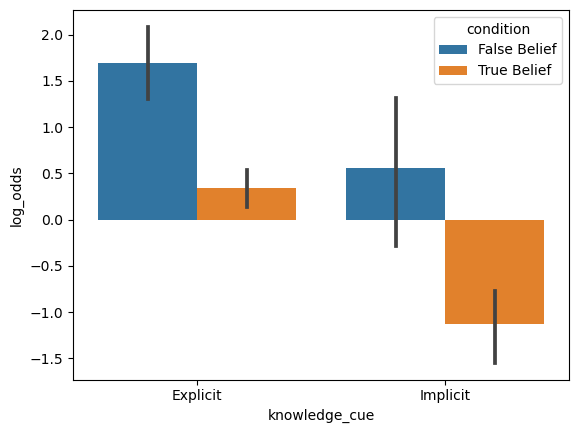

In [13]:
sns.barplot(data = df_results, x = "knowledge_cue", y = "log_odds", hue = "condition")

In [ ]:
def calculate_accuracy(row):
    if row['condition'] == 'False Belief':
        return row['log_odds'] > 0
    else:
        return row['log_odds'] < 0

In [15]:
df_results['correct'] = df_results.apply(calculate_accuracy, axis = 1)

In [16]:
df_results['correct'].mean()

0.78125

In [32]:
import sys

In [33]:
sys.executable

'/Users/seantrott/anaconda3/bin/python'